In [1]:
# --- Importing Libraries ---
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import joblib

/Users/madhumitha/Downloads/FlaskSentimentAnalyzer-main/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Load Data ---
print("Loading dataset...")
dataset = pd.read_csv('Restaurant_Reviews.tsv', delimiter='\t', quoting=3)
print("Dataset loaded successfully.")
# dataset.head()

Loading dataset...
Dataset loaded successfully.


In [3]:
# --- Data Preprocessing ---
# Replace non-letters is less crucial for BERT but can still be done if desired.
# BERT handles raw text well, so we'll just use the tokenizer.

reviews = dataset['Review'].values
labels = dataset['Liked'].values

# Load BERT tokenizer
print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize all reviews
print("Tokenizing data...")
input_ids = []
attention_masks = []

# Max length for BERT is 512, but reviews are likely shorter. Let's find max len or pick a safe one like 128.
MAX_LEN = 128 

for review in reviews:
    encoded_dict = tokenizer.encode_plus(
                        review,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        padding='max_length',      # Pad to max_length
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print("Tokenization complete.")

Loading BERT tokenizer...
Tokenizing data...
Tokenization complete.


In [4]:
# --- Split Data ---
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.2)
train_masks, test_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.2)

# Create the DataLoaders
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [5]:
# --- Initialize BERT Model ---
print("Loading BERT model...")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU if available.
device = torch.device("mps") if torch.backends.mps.is_available() else (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Using device: {device}")
model.to(device)

Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: mps


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [6]:
# --- Optimizer ---
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [7]:
# --- Training Loop ---
epochs = 10 

# Store the average loss after each epoch so we can plot them.
loss_values = []

print("Start Training...")

for epoch_i in range(0, epochs):
    print(f'\n======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    total_train_loss = 0
    model.train()

    for step, batch in enumerate(tqdm(train_dataloader)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)
    print(f"  Average training loss: {avg_train_loss:.2f}")

print("\nTraining complete!")

Start Training...

======== Epoch 1 / 10 ========
Training...


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


  Average training loss: 0.48

======== Epoch 2 / 10 ========
Training...


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


  Average training loss: 0.15

======== Epoch 3 / 10 ========
Training...


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


  Average training loss: 0.04

======== Epoch 4 / 10 ========
Training...


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


  Average training loss: 0.02

======== Epoch 5 / 10 ========
Training...


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


  Average training loss: 0.01

======== Epoch 6 / 10 ========
Training...


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


  Average training loss: 0.01

======== Epoch 7 / 10 ========
Training...


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


  Average training loss: 0.01

======== Epoch 8 / 10 ========
Training...


100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


  Average training loss: 0.00

======== Epoch 9 / 10 ========
Training...


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


  Average training loss: 0.01

======== Epoch 10 / 10 ========
Training...


100%|██████████| 50/50 [00:53<00:00,  1.06s/it]

  Average training loss: 0.00

Training complete!


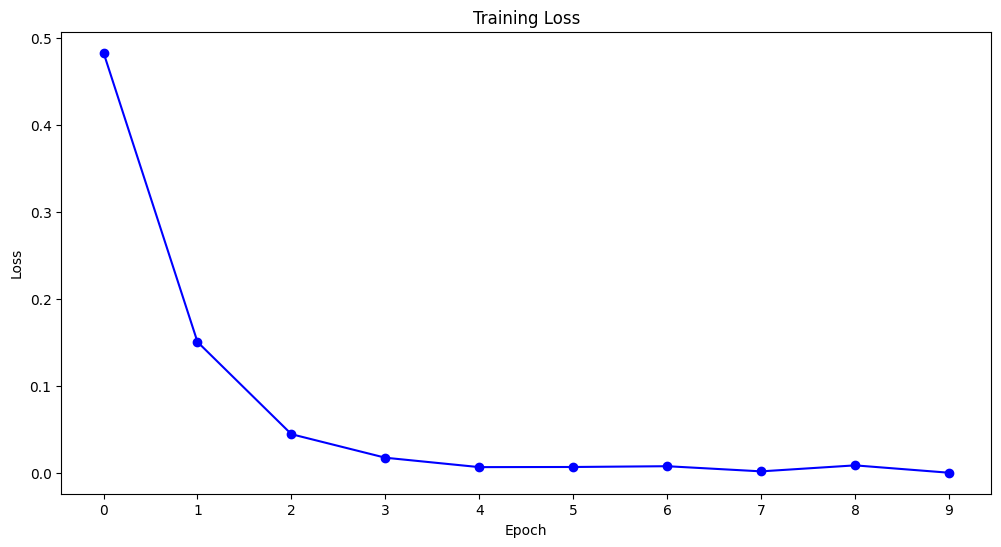

In [8]:
# --- Plot Training Loss ---
plt.figure(figsize=(12, 6))
plt.plot(loss_values, 'b-o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(epochs))
plt.show()

In [9]:
# --- Evaluation ---
print("Running Evaluation...")

model.eval()

predictions , true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  logits = outputs.logits
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.extend(np.argmax(logits, axis=1).flatten())
  true_labels.extend(label_ids.flatten())

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=['Negative', 'Positive']))

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

Running Evaluation...

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      1.00      0.94        96
    Positive       1.00      0.88      0.94       104

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.95      0.94      0.94       200

Accuracy: 0.9400


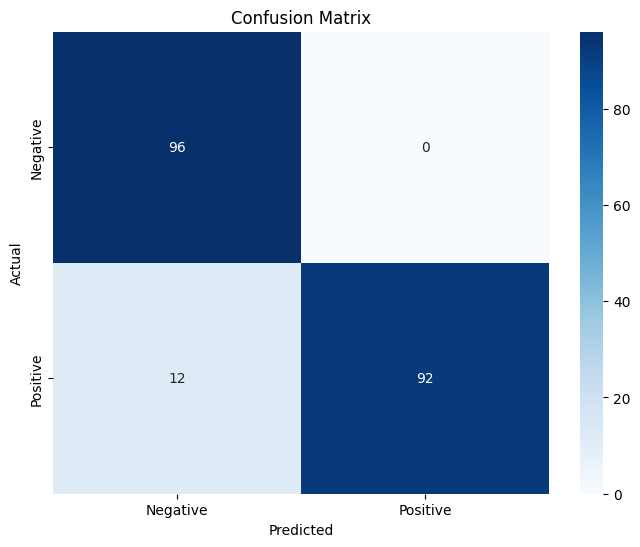

In [10]:
# --- Plot Confusion Matrix ---
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# --- Save Model ---
output_dir = './model_bert/'
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print("Model saved to directory.")

# --- Save as Pickle ---
pickle_file = 'sentiment_model_bert.pkl'
print(f"Saving model to {pickle_file}...")
# We save the model state dict or the model object. 
# Note: Saving the entire model object with joblib includes the architecture def,
# but requires transformers to be installed to load.
joblib.dump(model, pickle_file)
print("Model saved as pickle file.")

Saving model to ./model_bert/
Model saved to directory.
Saving model to sentiment_model_bert.pkl...
Model saved as pickle file.
